In [1]:
from IPython.display import Markdown as md

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import LSTM, Dense, Input, TimeDistributed, Concatenate, Lambda, Bidirectional, Dropout, RNN
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD

import spektral
from spektral.layers import GraphConv, GraphAttention, GlobalAttentionPool

import seaborn as sns
import numpy as np
import pandas as pd

from data_preparation import *
from visualization import *
from subgraphing import Subgraphing
from custom_lstm_cell import CustomLSTMCell
from graph_reduce_cell import GraphReduceCell
from submit import *

import time

In [2]:
STACKED_FEATURES_SIZE = 14
EDGES_FEATURES_MATRIX_DEPTH = 3
NEIGHBOURHOOD_SIZE = 20
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
# LOADING DATASETS FROM DISK (CREATE THEM IF THEY DON'T EXIST)
train_valid_ds, public_test_ds, private_test_ds = load_base_datasets() 

In [3]:
# LOADING SUBGRAPHED DATASETS FROM DISK (CREATE_THEM IF THEY DON'T EXIST)
subgraphed_train_valid_ds, subgraphed_public_test_ds, subgraphed_private_test_ds = load_subgraphed_datasets(neighbourhood_size=20) 

In [5]:
inspect_dataset_columns(train_valid_ds)

FEATURES:


,feature_name,tensor_shape
0,sequence,"(68, 4)"
1,structure,"(68, 3)"
2,predicted_loop_type,"(68, 7)"
3,adjacency_matrix,"(68, 68)"
4,edges_features_matrix,"(68, 68, 3)"
5,seq_scored,()
6,stacked_base_features,"(68, 14)"



LABELS:


,label_name,tensor_shape
0,stacked_scored_labels,"(68, 3)"


dataset cardinality: 2400


In [17]:
# inspect_dataset_columns(subgraphed_train_valid_ds)

In [23]:
subgraphed_train_valid_ds = subgraphed_train_valid_ds.prefetch(AUTOTUNE).cache().batch(BATCH_SIZE)
subgraphed_public_test_ds = subgraphed_public_test_ds.prefetch(AUTOTUNE).cache().batch(BATCH_SIZE)
subgraphed_private_test_ds = subgraphed_private_test_ds.prefetch(AUTOTUNE).cache().batch(BATCH_SIZE)

In [25]:
def mcrmse(y_true, y_pred):
    rmse = tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred), axis=1))
    return tf.reduce_mean(rmse, axis=1)

In [26]:
# MODEL FOR SUBGRAPHED INPUTS
base_inputs = Input(shape = (None, NEIGHBOURHOOD_SIZE, STACKED_FEATURES_SIZE), name='stacked_base_features')
adjacency_matrix_inputs = Input(shape=(NEIGHBOURHOOD_SIZE, None, None), name='adjacency_matrix')
edges_features_matrix_inputs = Input(shape=(NEIGHBOURHOOD_SIZE, None, None, EDGES_FEATURES_MATRIX_DEPTH), name='edges_features_matrix')

inputs = (base_inputs, adjacency_matrix_inputs, edges_features_matrix_inputs)

x = RNN(GraphReduceCell(64), return_sequences=True)(inputs)

reactivity_pred = TimeDistributed(Dense(1), name='reactivity')(x)
deg_Mg_pH10_pred = TimeDistributed(Dense(1), name='deg_Mg_pH10')(x)
deg_Mg_50C_pred = TimeDistributed(Dense(1), name='deg_Mg_50C')(x)

scored_outputs = [reactivity_pred, deg_Mg_pH10_pred, deg_Mg_50C_pred]
stacked_scored_outputs = Concatenate(axis=2, name='stacked_outputs')(scored_outputs)
outputs = {'stacked_scored_labels': stacked_scored_outputs}

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss=mcrmse)

In [27]:
model.evaluate(subgraphed_train_valid_ds)

/home/patryk/.local/share/virtualenvs/covid-IONWklol/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['sequence', 'structure', 'predicted_loop_type', 'seq_scored'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


75/75 [==============================] - 5s 64ms/step - loss: 1.0305


1.0305026769638062

In [29]:
model.save('./models/example_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./models/example_model/assets


In [70]:
loaded_model = tf.keras.models.load_model('./models/example_model', custom_objects = {'mcrmse': mcrmse, 'GraphReduceCell': GraphReduceCell})

TypeError: ('Keyword argument not understood:', 'conv_graph_layer')

In [61]:
base_inputs = Input(shape = (None, STACKED_FEATURES_SIZE), name='stacked_base_features')
adjacency_matrix_inputs = Input(shape=(None, None), name='adjacency_matrix')
edges_features_matrix_inputs = Input(shape=(None, None, EDGES_FEATURES_MATRIX_DEPTH), name='edges_features_matrix')

inputs = (base_inputs, adjacency_matrix_inputs, edges_features_matrix_inputs)

subgraphed = Subgraphing(10)(inputs)

lol_model = Model(inputs=inputs, outputs=subgraphed)

lol_model.compile(optimizer='adam', loss=mcrmse)

In [63]:
lol_model.evaluate(private_test_ds.take(2).batch(2))

1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - subgraphing_6_loss: 0.0000e+00 - subgraphing_6_1_loss: 0.0000e+00 - subgraphing_6_2_loss: 0.0000e+00


/home/patryk/.local/share/virtualenvs/covid-IONWklol/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['sequence', 'structure', 'predicted_loop_type', 'seq_scored'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


[0.0, 0.0, 0.0, 0.0]

In [64]:
lol_model.save('./models/lol_model')

INFO:tensorflow:Assets written to: ./models/lol_model/assets


In [66]:
loaded_lol_model = tf.keras.models.load_model('./models/lol_model', custom_objects={'mcrmse': mcrmse})

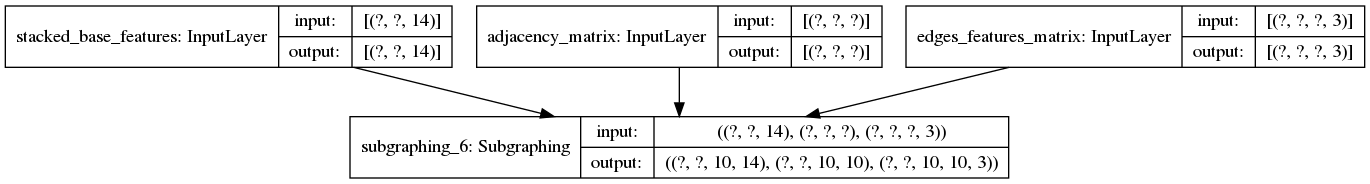

In [67]:
tf.keras.utils.plot_model(loaded_lol_model,  show_shapes=True)

In [69]:
loaded_lol_model.evaluate(train_valid_ds.take(2).batch(2))

ValueError: in user code:

    /home/patryk/.local/share/virtualenvs/covid-IONWklol/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1224 test_function  *
        return step_function(self, iterator)
    /home/patryk/.local/share/virtualenvs/covid-IONWklol/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1215 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/patryk/.local/share/virtualenvs/covid-IONWklol/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/patryk/.local/share/virtualenvs/covid-IONWklol/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/patryk/.local/share/virtualenvs/covid-IONWklol/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/patryk/.local/share/virtualenvs/covid-IONWklol/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1208 run_step  **
        outputs = model.test_step(data)
    /home/patryk/.local/share/virtualenvs/covid-IONWklol/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1177 test_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    /home/patryk/.local/share/virtualenvs/covid-IONWklol/lib/python3.7/site-packages/tensorflow/python/keras/engine/compile_utils.py:183 __call__
        y_true = self._conform_to_outputs(y_pred, y_true)
    /home/patryk/.local/share/virtualenvs/covid-IONWklol/lib/python3.7/site-packages/tensorflow/python/keras/engine/compile_utils.py:63 _conform_to_outputs
        struct = map_to_output_names(outputs, self._output_names, struct)
    /home/patryk/.local/share/virtualenvs/covid-IONWklol/lib/python3.7/site-packages/tensorflow/python/keras/engine/compile_utils.py:588 map_to_output_names
        struct.keys(), output_names))

    ValueError: Found unexpected keys that do not correspond to any Model output: dict_keys(['stacked_scored_labels']). Expected: ['subgraphing_6', 'subgraphing_6_1', 'subgraphing_6_2']
